In [20]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt 
import helper
from sklearn.metrics import classification_report
import copy

### Overfitting
Sau khi thực hiện huấn luyện mô hình trên tập dữ liệu. Nhận thấy rằng đối với mô hình Feedforward Neural Network, mô hình có xu hướng rất tốt nên không cần phải thực hiện các giải pháp để giảm overfitting. <br>
Đối với mô hình Recurrent Neural Network, mô hình có xu hướng overfitting dựa trên độ đo (metrics) độ chính xác (accuracy ~ 0.6952). Vì vậy, chúng em chọn sử dụng mô hình Recurrent Neural Network để thực hiện giải pháp giảm overfitting. Cụ thể là sử dụng giải pháp Dropout để giảm độ phức tạp của mô hình học máy và Early Stopping. <br>
Giải pháp Early Stopping sẽ giúp ta giảm overfitting bằng cách dừng quá trình huấn luyện mô hình học máy khi độ chính xác trên tập dữ liệu kiểm thử không còn tăng nữa. <br>
Để thực hiện giải pháp Early Stopping, ta sẽ sử dụng EarlyStopping callback của thư viện Keras.

In [21]:
df = pd.read_csv('./TrafficTwoMonth.csv')

In [22]:
traffic_sistuation = {
    'low': 0,
    'normal': 1,
    'high': 2, 
    'heavy':3
}

In [23]:
new_df = copy.copy(df)
new_df = new_df.drop(["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"], axis=1)
new_df2 = copy.copy(new_df)
new_df2['Datetime'] = new_df2.apply(lambda x: helper.generate_datetime(x['Time'], x['Date'], x['Day of the week']), axis=1) 
new_df3 = new_df2.set_index('Datetime')
new_df4 = new_df3.drop(['Time', 'Date', 'Day of the week'], axis=1)
new_df4['Traffic Situation'] = new_df4['Traffic Situation'].replace(traffic_sistuation)
new_df4

,Traffic Situation
Datetime,
2023-12-12 00:00:00,1
2023-12-12 00:15:00,1
2023-12-12 00:30:00,1
2023-12-12 00:45:00,1
2023-12-12 01:00:00,1
...,...
2023-12-14 22:45:00,1
2023-12-14 23:00:00,1
2023-12-14 23:15:00,1


In [24]:
data = pd.get_dummies(new_df4.to_numpy().reshape(-1), dtype=int).values
data

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [25]:
timestep = 30

X = []
y = []

n = len(data)

for i in range(n - (timestep)):
    X.append(data[i:i+timestep])
    y.append(data[i+timestep])

X = np.asanyarray(X)
y = np.asanyarray(y)


index_test = 5000
X_train = X[:index_test,:,:]
X_test = X[index_test:,:,:]
y_train = y[:index_test]    
y_test= y[index_test:]  

In [26]:
from keras.callbacks import EarlyStopping

In [27]:
model_drop = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax'),
])

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_drop = model_drop.fit(X_train, y_train, epochs=20, batch_size=100, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/20
40/40 [==============================] - 2s 15ms/step - loss: 1.1541 - accuracy: 0.5935 - val_loss: 1.1122 - val_accuracy: 0.5450
Epoch 2/20
40/40 [==============================] - 0s 9ms/step - loss: 0.9453 - accuracy: 0.6590 - val_loss: 1.0181 - val_accuracy: 0.5910
Epoch 3/20
40/40 [==============================] - 0s 11ms/step - loss: 0.8798 - accuracy: 0.6768 - val_loss: 0.9510 - val_accuracy: 0.6350
Epoch 4/20
40/40 [==============================] - 0s 11ms/step - loss: 0.8669 - accuracy: 0.6865 - val_loss: 1.0004 - val_accuracy: 0.6310
Epoch 5/20
40/40 [==============================] - 0s 11ms/step - loss: 0.8408 - accuracy: 0.7007 - val_loss: 0.9184 - val_accuracy: 0.6680
Epoch 6/20
40/40 [==============================] - 0s 11ms/step - loss: 0.8227 - accuracy: 0.7057 - val_loss: 0.9131 - val_accuracy: 0.6730
Epoch 7/20
40/40 [==============================] - 0s 11ms/step - loss: 0.8189 - accuracy: 0.7025 - val_loss: 0.8987 - val_accuracy: 0.6720
Epoch 8/20
40/

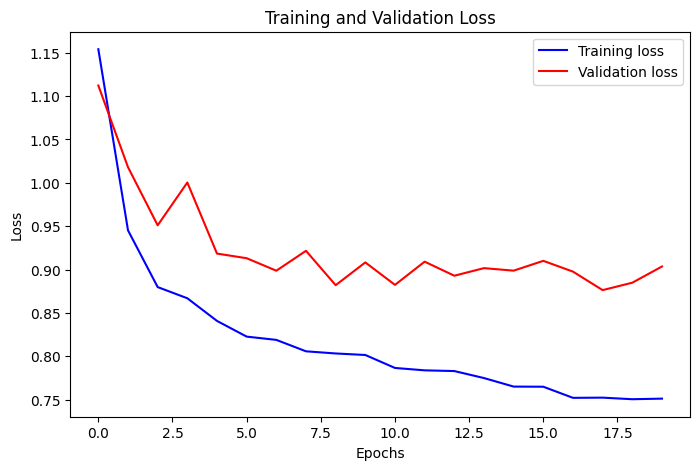

In [28]:
helper.plot_Loss_Val(history_drop)

#### Kết quả
Sau khi thực hiện giải pháp Dropout (để giảm độ phức tạp của mô hình) và Early Stopping, độ chính xác trên tập dữ liệu huấn luyện đã giảm từ 0.6875 xuống 0.6765. Tuy nhiên, độ chính xác trên tập dữ liệu kiểm thử vẫn giữ nguyên ~ 0.6952. Điều này chứng tỏ mô hình đã không còn overfitting nữa. <br>
Trước khi thực hiện giải pháp Dropout và Early Stopping:
```terminal
...
Epoch 199/200
48/48 [==============================] - 0s 6ms/step - loss: 0.8547 - accuracy: 0.6856 - val_loss: 0.8476 - val_accuracy: 0.6952
Epoch 200/200
48/48 [==============================] - 0s 5ms/step - loss: 0.8547 - accuracy: 0.6875 - val_loss: 0.8468 - val_accuracy: 0.6952
```
Sau khi thực hiện giải pháp Dropout và Early Stopping:
```terminal
...
Epoch 199/200
48/48 [==============================] - 0s 5ms/step - loss: 0.8747 - accuracy: 0.6776 - val_loss: 0.8474 - val_accuracy: 0.6952
Epoch 200/200
48/48 [==============================] - 0s 6ms/step - loss: 0.8771 - accuracy: 0.6765 - val_loss: 0.8473 - val_accuracy: 0.6952
```

Đoạn code sau đây thực hiện giải pháp tránh overfitting bằng phương pháp L2 regularization.

In [29]:
from keras.regularizers import l2

In [30]:
model_l2 = keras.models.Sequential([
    layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    layers.Dense(4, activation='softmax'),
])
model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_l2 = model_l2.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=100)

Epoch 1/20
40/40 [==============================] - 2s 16ms/step - loss: 1.2267 - accuracy: 0.6173 - val_loss: 1.1941 - val_accuracy: 0.5220
Epoch 2/20
40/40 [==============================] - 0s 12ms/step - loss: 0.9930 - accuracy: 0.6428 - val_loss: 1.1330 - val_accuracy: 0.5290
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.9451 - accuracy: 0.6515 - val_loss: 1.1098 - val_accuracy: 0.5600
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.9170 - accuracy: 0.6720 - val_loss: 1.0301 - val_accuracy: 0.6180
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 0.8528 - accuracy: 0.6933 - val_loss: 0.9685 - val_accuracy: 0.6480
Epoch 6/20
40/40 [==============================] - 1s 15ms/step - loss: 0.8183 - accuracy: 0.7065 - val_loss: 0.9596 - val_accuracy: 0.6560
Epoch 7/20
40/40 [==============================] - 1s 13ms/step - loss: 0.8053 - accuracy: 0.7128 - val_loss: 0.9410 - val_accuracy: 0.6750
Epoch 8/20
40

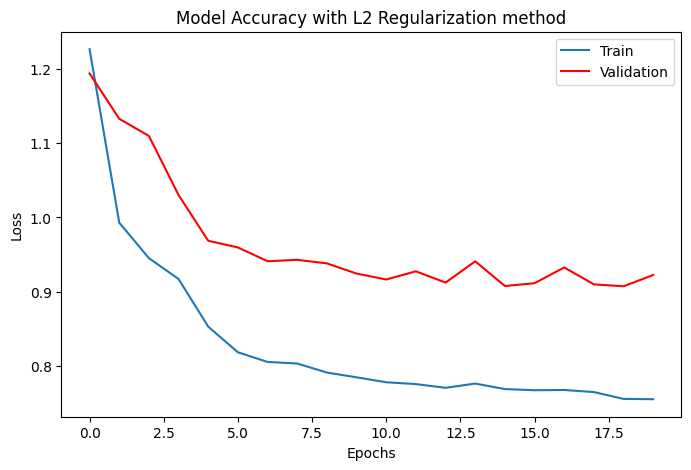

In [31]:
plt.figure(figsize=(8,5))
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'], c='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Model Accuracy with L2 Regularization method")
plt.show()

### Cải thiện độ chính xác

#### Giải pháp sử dụng LSTM đa chiều
Giải pháp sử dụng LSTM đa chiều sẽ giúp ta cải thiện độ chính xác bằng cách sử dụng LSTM đa chiều (Bidirectional LSTM) thay vì sử dụng LSTM đơn chiều (LSTM). <br>
Qua đó, lớp LSTM đa chiều (Bidirectional LSTM) sẽ giúp ta cải thiện độ chính xác bằng cách xem xét cả thông tin từ quá khứ và tương lai. <br>
Để thực hiện giải pháp sử dụng LSTM đa chiều, ta sẽ sử dụng lớp Bidirectional của thư viện Keras. <br>

In [13]:
model_bid = keras.models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_test.shape[2])),
    layers.Bidirectional(layers.LSTM(10, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(10)),
    layers.Dense(4, activation='softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_bid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bid.fit(X_train, y_train, epochs=50, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 9s 25ms/step - loss: 0.9852 - accuracy: 0.6445 - val_loss: 1.0649 - val_accuracy: 0.6000
Epoch 2/50
125/125 [==============================] - 2s 13ms/step - loss: 0.8503 - accuracy: 0.6975 - val_loss: 0.9254 - val_accuracy: 0.6710
Epoch 3/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7950 - accuracy: 0.7170 - val_loss: 0.8976 - val_accuracy: 0.6730
Epoch 4/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7693 - accuracy: 0.7222 - val_loss: 0.9030 - val_accuracy: 0.6670
Epoch 5/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7560 - accuracy: 0.7303 - val_loss: 0.8848 - val_accuracy: 0.6950
Epoch 6/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7421 - accuracy: 0.7340 - val_loss: 0.8722 - val_accuracy: 0.6860
Epoch 7/50
125/125 [==============================] - 2s 13ms/step - loss: 0.7307 - accuracy: 0.7350 - val_loss: 0.8924 - val_accuracy: 0.6840

#### Kết quả
Sau khi thực hiện giải pháp sử dụng LSTM đa chiều, độ chính xác trên tập dữ liệu kiểm thử đã tăng lên ~ 0.6969 (từ 0.6952) trong khi độ chính xác trên tập dữ liệu huấn luyện đã giảm xuống ~ 0.6845 (từ 0.6875). <br>
Mặc dù độ chính xác tăng lên không nhiều, nhưng độ ổn định, và hiệu suất học của mô hình đã được cải thiện. Cụ thể, từ sau epoch thứ 50, độ chính xác của mô hình đã không còn thay đổi và biến động nhiều như trước đó. Trong khi đó, độ chính xác của mô hình trước khi thực hiện giải pháp sử dụng LSTM đa chiều chỉ ổn định sau epoch thứ 100. Điều này vừa giúp ta tiết kiệm được thời gian huấn luyện mô hình, vừa giúp ta có thể tăng độ chính xác của mô hình. Ta cũng có thể áp dụng thêm Early Stopping để giảm thời gian huấn luyện mô hình khi độ chính xác của mô hình không còn thay đổi và biến động nhiều như trước đó. <br>
Sau khi thực hiện giải pháp sử dụng LSTM đa chiều:

Đánh giá kết quả sau khi train.\
Nhìn chung RNN model sau khi áp dụng các kĩ thuật cải thiện thì có tỉ lệ dự đóan cao hơn một ít.

In [14]:
loss, accuracy = model_bid.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

29/29 [==============================] - 0s 5ms/step - loss: 0.8321 - accuracy: 0.7169
Loss: 0.8320563435554504, Accuracy: 0.7169197201728821


In [19]:
y_pred = model_bid.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

29/29 [==============================] - 0s 6ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.25      0.35       151
           1       0.69      0.93      0.79       492
           2       0.00      0.00      0.00        62
           3       0.84      0.76      0.80       217

    accuracy                           0.72       922
   macro avg       0.54      0.49      0.49       922
weighted avg       0.67      0.72      0.67       922



c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phatt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,